# Development of functions to: 1. Find retro steps for input smiles target. 2. Exctract info needed to populate DB models 3. Extract robotic action steps and populate DB

In [1]:
from rdkit import Chem
from rxn4chemistry import RXN4ChemistryWrapper
import pandas as pd
import os
import time

In [26]:
# Setup IBM RxN API
api_key=os.environ['IBM_API_KEY'] 
rxn4chemistry_wrapper = RXN4ChemistryWrapper(api_key=api_key)
rxn4chemistry_wrapper.create_project('Test actions 1')

{'response': {'payload': {'id': '5fcf5ae5a8d96500011c2f70',
   'metadata': {},
   'embed': {},
   'computedFields': {},
   'createdOn': 1607424741736,
   'createdBy': '5421668d-2db4-4064-a1e6-f77e33938145',
   'modifiedOn': 1607424741736,
   'modifiedBy': '5421668d-2db4-4064-a1e6-f77e33938145',
   'name': 'Test actions 1',
   'description': None,
   'attempts': [],
   'visibility': None},
  'metadata': {'uiMessages': {'errors': [], 'infos': [], 'warnings': []},
   'extendedPagination': {}}}}

In [3]:
test =pd.read_csv('/home/warren/XChem_projects/car-django-react/Test_DB_files/csv_upload.csv')
test

,Targets,Ammount_required (mg)
0,Cc1ccccc1-c1cccc(NC(=O)Cc2cccc(O)c2)c1\t,10.25
1,COc1ccc(C)cc1NC(=O)Cc1cccc(O)c1\t,10.00
2,Oc1ccccc1NC(=O)Cc1cccc(O)c1\t,10.00
3,O=C(Cc1cccc(O)c1)Nc1ccc(F)cc1F\t,10.00
4,Cc1cc(C)c(NC(=O)Cc2cccc(O)c2)c(C)c1\t,10.00
5,O=C(Cc1cccc(O)c1)NCC1COc2ccccc2O1\t,10.00
6,O=C(Cc1cccc(O)c1)Nc1ccccc1OC(F)(F)F\t,10.00
7,Cn1cc(NC(=O)Cc2cccc(O)c2)cn1\t,10.00
8,O=C(Cc1cccc(O)c1)Nc1cn[nH]c1\t,10.00
9,CC(NC(=O)Cc1cccc(O)c1)c1ccccc1Cl\t,10.00


In [8]:
#from celery import shared_task 

# CSV check functions
def add_warning(target_name, field, warning_string, validate_dict):
    validate_dict['target_name'].append(target_name)
    validate_dict['field'].append(field)
    validate_dict['warning_string'].append(warning_string)

    return validate_dict

def checkColumnName(column_name, validate_dict):
    if column_name != 'Targets':
        validate_dict = add_warning(target_name = 'Column name error',
                                    field = 'column_name',
                                    warning_string = "Column name set to {} and should be 'Targets'".format(column_name),
                                    validate_dict=validate_dict)
    return validate_dict


def checkNumberColumns(columns, validate_dict):
    no_columns = len(columns)
    
    if no_columns > 1:
        validate_dict = add_warning(target_name = 'Column name error',
                                    field = 'column_name',
                                    warning_string = "Found {} column names. Set and name columns to 'Targets' only".format(no_columns),
                                    validate_dict=validate_dict)
        
    if no_columns == 1:
        validate_dict = checkColumnName(columns[0], validate_dict)
    
    return validate_dict


def checkSMILES(target_smiles, index, validate_dict):
    
    mol = Chem.MolFromSmiles(target_smiles)
    
    if mol is None:
        validate_dict = add_warning(target_name = target_smiles,
                            field = 'smiles_check',
                            warning_string = "Input target smiles: '{}' at index {} is not a valid smiles".format(target_smiles, index),
                            validate_dict=validate_dict)

    return validate_dict


# @shared_task
def validateFileUpload(csv_fp, project_info=None, validate_only=True):
    """ Celery task to process validate the uploaded files for retrosynthesis planning.
    
    Parameters
    ----------
    csv_fp: str
        filepath of the uploaded csv file, which is saved to temporary storage by `viewer.views.UploadCSV`
    project_info: dict
        dictionary of project details (name, email and project_name) that will be used to create the project model
        if the csv file is validated
    validate_only: boolean
        set to True to delete tmp file saved for validation and set to False to save tmp file and keep
        for uploading and creating model objects
    
    Returns
    -------
    validate_output: tuple
        contains the following:
            - validate dict (dict): dict containing any errors found during the validation step
            - validated (bool): True if the file(s) were validated, False if not
            - filename (str): name of the uploaded csv file
    """
    
    validated = True
    smiles_list = []
    
    validate_dict = {'target_name': [],
                     'field': [],
                     'warning_string': []}
    
    # Open csv file as Pandas df
    uploaded_csv_df = pd.read_csv(csv_fp)
    
    # Check no of column headings and name of column heading
    columns = uploaded_csv_df.columns
    validate_dict = checkNumberColumns(columns, validate_dict)
    
    if len(validate_dict['target_name']) != 0:
        validated = False
    else:
        # Check SMILES - make this better
        indexes = [i for i,smi in enumerate(uploaded_csv_df['Targets'])]
        smiles_list = [smi for i, smi in enumerate(uploaded_csv_df['Targets'])]
        
        for smi, index in zip(smiles_list, indexes): 
            validate_dict = checkSMILES(smi, index, validate_dict)

    if len(validate_dict['target_name']) !=0:
        validated = False
    
    # Delete tempory file if only validate selected
#     if validate_only:
#         default_storage.delete(csv_fp)
#         csv_fp = None
      
    return (validate_dict, validated, csv_fp, project_info, smiles_list)



In [9]:
dic,val,csv, project,smiles = validateFileUpload('/home/warren/XChem_projects/car-django-react/Test_DB_files/csv_upload.csv')

In [10]:
smiles

[]

In [6]:
# Function to get reactions from IBM API
def getIBMRetroSyn(smiles):
        """
        Use the IBM API to get some possible retrosynthesis routes
        """
        # Create dummy dictionary to create while loop to catch when status is a SUCCESS
        results = {}
        results['status'] = None
        final_results = None

        while final_results is None:  
            try:
                response = rxn4chemistry_wrapper.predict_automatic_retrosynthesis(product=smiles, max_steps=3)
                while results['status'] != 'SUCCESS': 
                    time.sleep(130)
                    results = rxn4chemistry_wrapper.get_predict_automatic_retrosynthesis_results(response['prediction_id'])
                    final_results = results
            except Exception as e:
                print(e)
        return final_results


In [32]:
rxn4chemistry_wrapper.set_project('5fcf5ae5a8d96500011c2f70')

In [11]:
results = getIBMRetroSyn('Cc1ccccc1-c1cccc(NC(=O)Cc2cccc(O)c2)c1')

In [38]:
results['retrosynthetic_paths'][0]

{'id': '5fcf57d0a8d96500011c2dcd',
 'metadata': {},
 'embed': {},
 'computedFields': {},
 'createdOn': 1607423952578,
 'createdBy': 'system',
 'modifiedOn': 1607423952578,
 'modifiedBy': 'system',
 'moleculeId': '5f4863123dc67c0001c8900b',
 'retrosynthesisId': '5fcf57caa8d96500011c2dc5',
 'sequenceId': '5fcf57d0a8d96500011c2dca',
 'projectId': '5fcf574aa8d96500011c2da8',
 'smiles': 'Cc1ccccc1-c1cccc(NC(=O)Cc2cccc(O)c2)c1',
 'confidence': 1.0,
 'confidenceTag': None,
 'rclass': 'Carboxylic acid + amine condensation',
 'hasFeedback': False,
 'feedback': None,
 'children': [{'id': '5fcf57d0a8d96500011c2dcb',
   'metadata': {},
   'embed': {},
   'computedFields': {},
   'createdOn': 1607423952558,
   'createdBy': 'system',
   'modifiedOn': 1607423952558,
   'modifiedBy': 'system',
   'moleculeId': '5ecd82053cdbb300019d83fc',
   'retrosynthesisId': '5fcf57caa8d96500011c2dc5',
   'sequenceId': '5fcf57d0a8d96500011c2dca',
   'projectId': '5fcf574aa8d96500011c2da8',
   'smiles': 'Cc1ccccc1-c1

In [41]:
for pathway in results['retrosynthetic_paths']:
    print(pathway['rclass'])

Carboxylic acid + amine condensation
Bromo Suzuki-type coupling
Methoxy to hydroxy
O-Bn deprotection
Iodo Suzuki-type coupling
Iodo Suzuki-type coupling
Iodo Suzuki-type coupling
Iodo Suzuki-type coupling
Iodo Suzuki-type coupling
Bromo Suzuki-type coupling
Bromo Suzuki-type coupling
Bromo Suzuki-type coupling
Bromo Suzuki-type coupling
Bromo Suzuki-type coupling
Methoxy to hydroxy
Methoxy to hydroxy
Methoxy to hydroxy
Methoxy to hydroxy
Methoxy to hydroxy
Methoxy to hydroxy
Methoxy to hydroxy
O-Bn deprotection
O-Bn deprotection
O-Bn deprotection
O-Bn deprotection
O-Bn deprotection
Iodo Suzuki-type coupling
Bromo Suzuki-type coupling
Methoxy to hydroxy
Bromo Suzuki-type coupling


Showing path 0 with confidence 1.0:


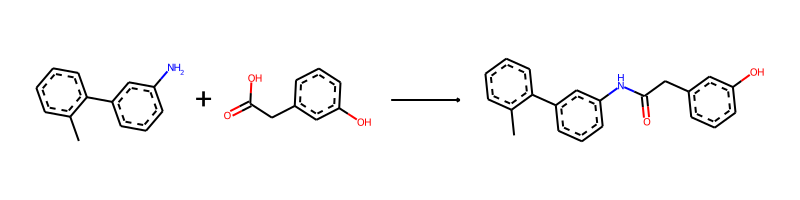

Showing path 1 with confidence 1.0:


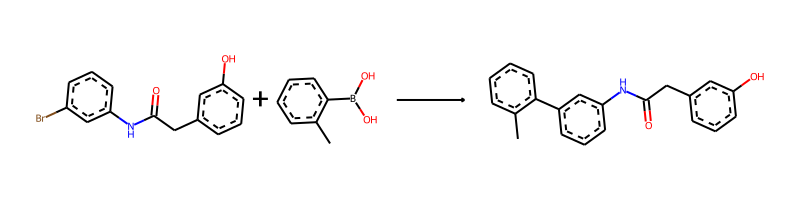

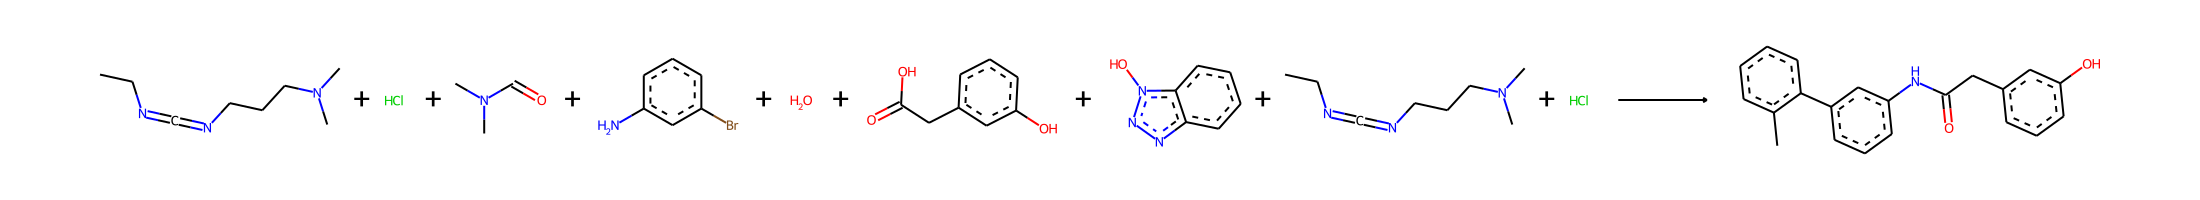

Showing path 2 with confidence 1.0:


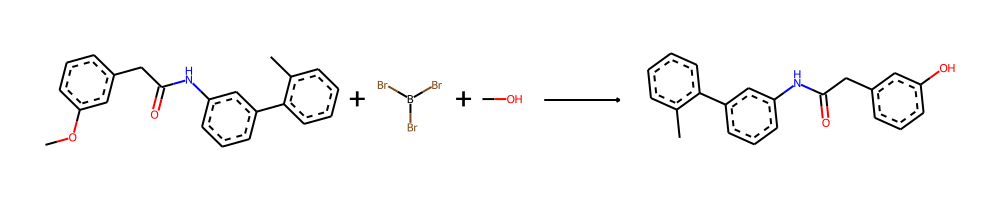

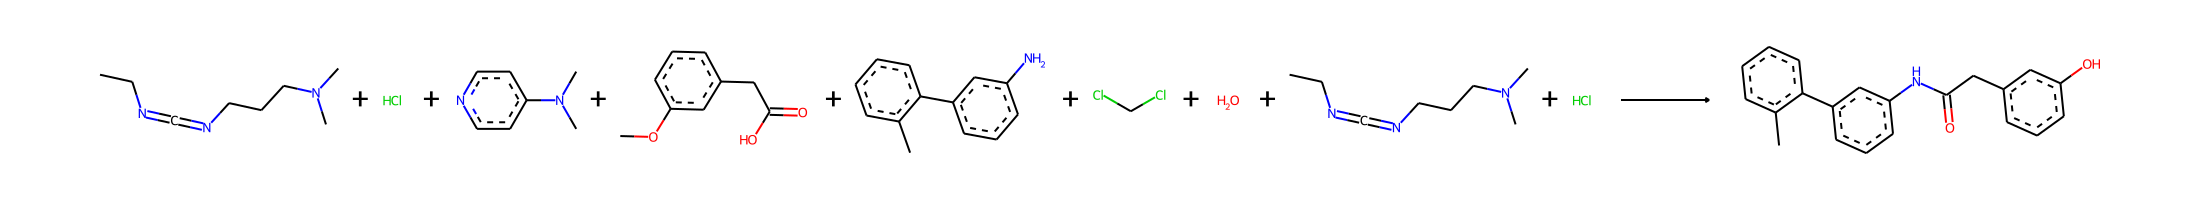

Showing path 3 with confidence 1.0:


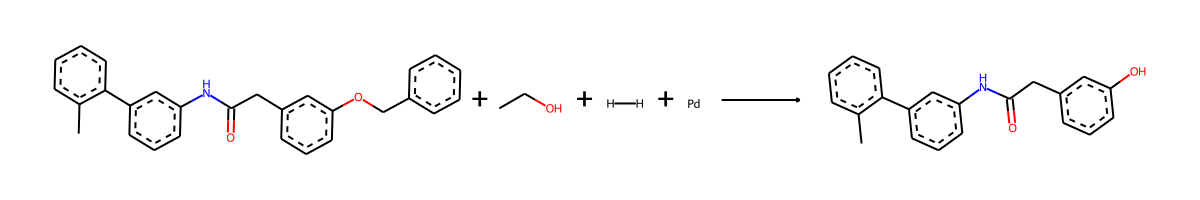

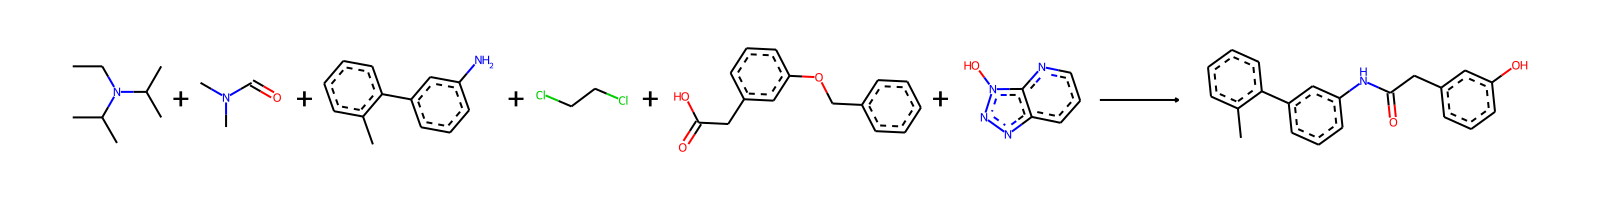

Showing path 4 with confidence 1.0:


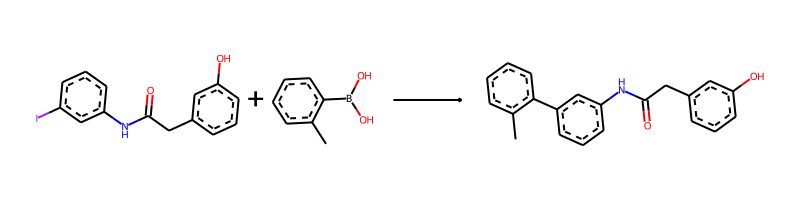

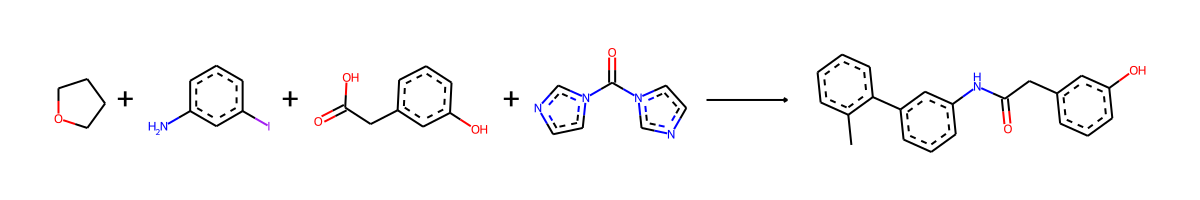

Showing path 5 with confidence 1.0:


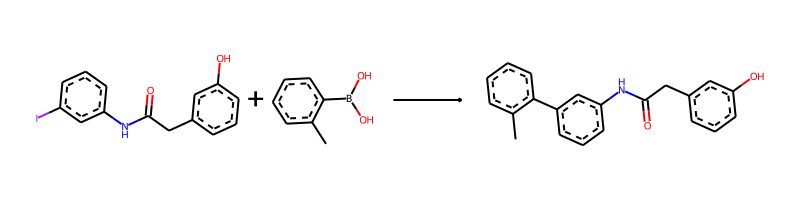

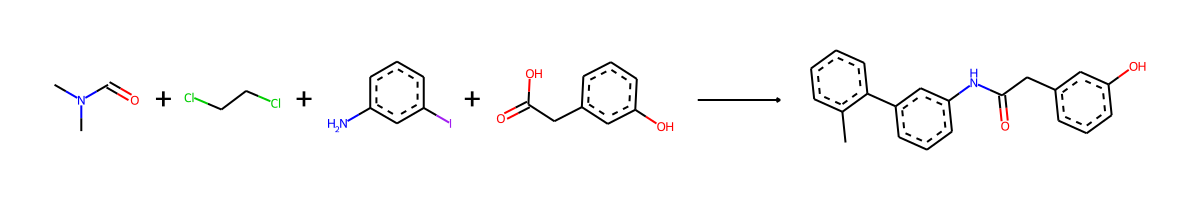

Showing path 6 with confidence 1.0:


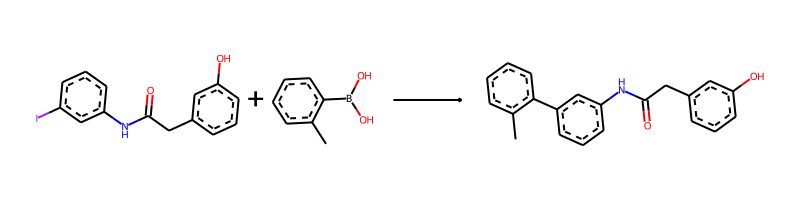

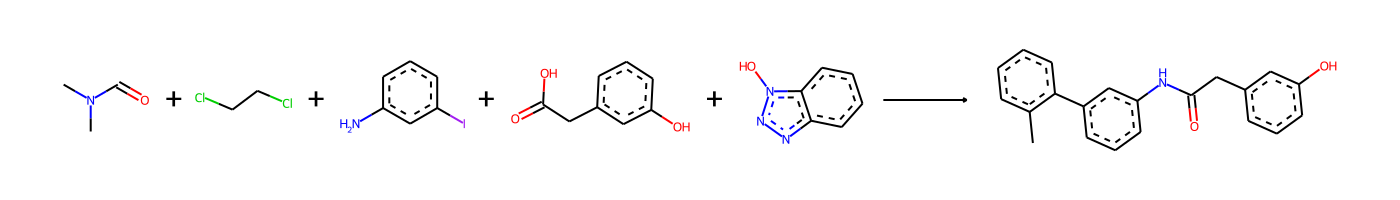

Showing path 7 with confidence 1.0:


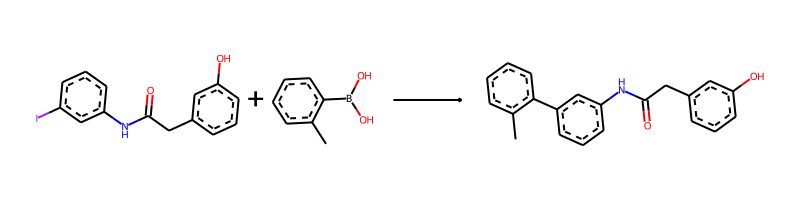

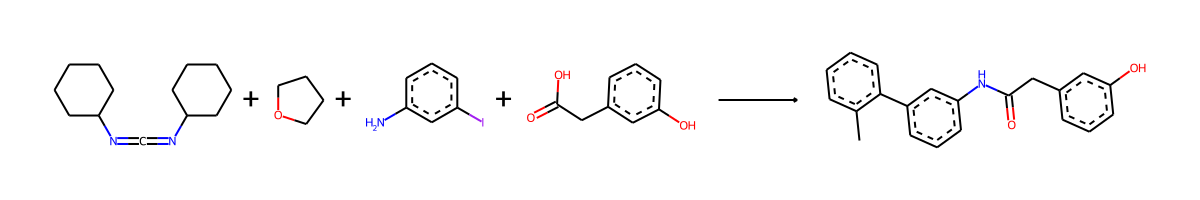

Showing path 8 with confidence 1.0:


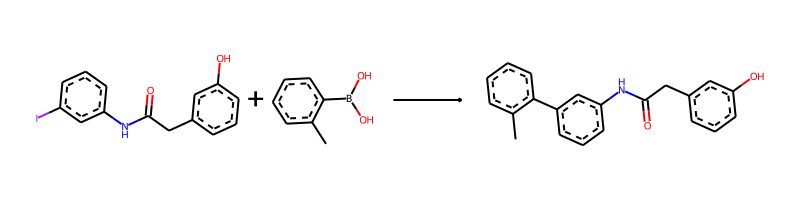

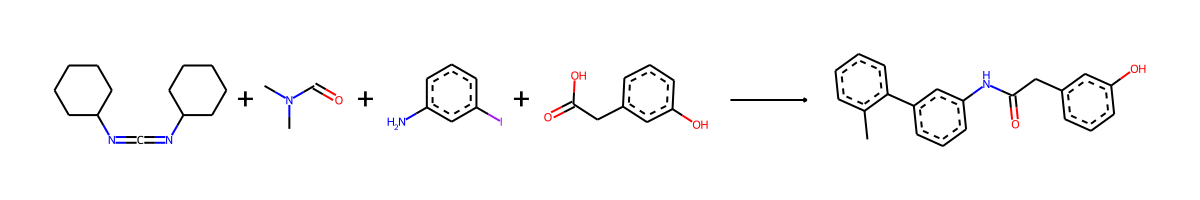

Showing path 9 with confidence 1.0:


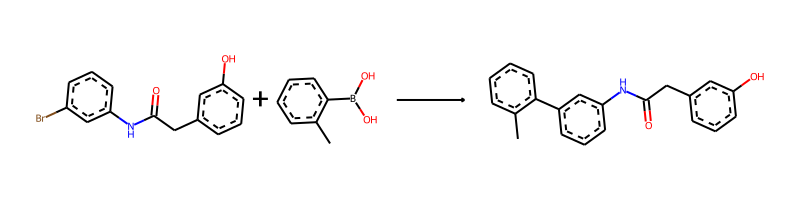

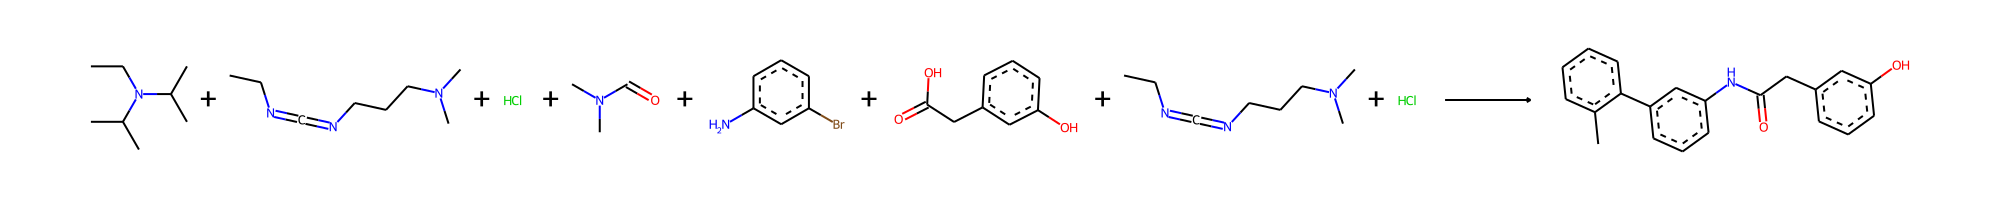

Showing path 10 with confidence 1.0:


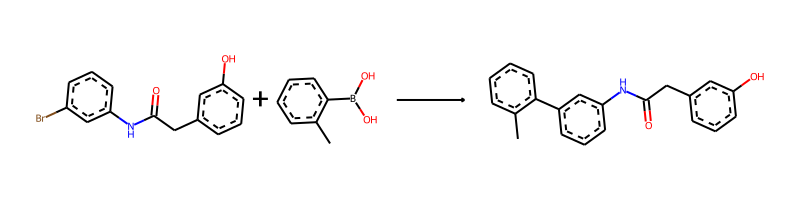

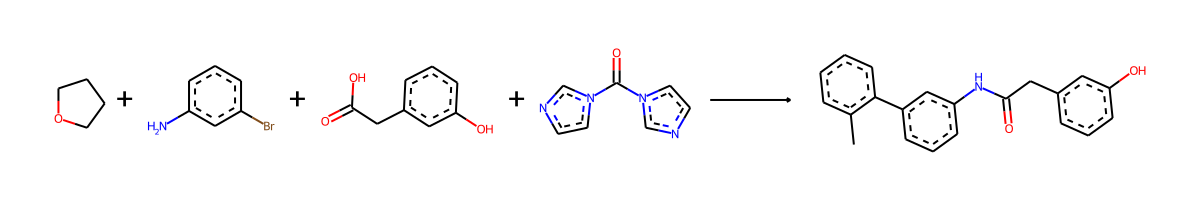

Showing path 11 with confidence 1.0:


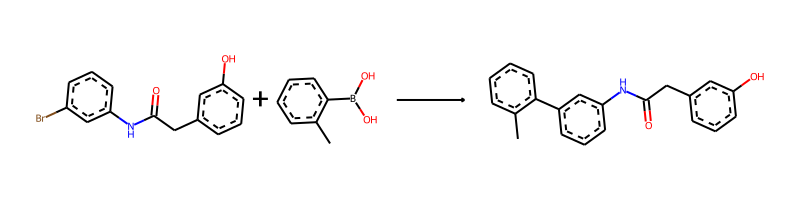

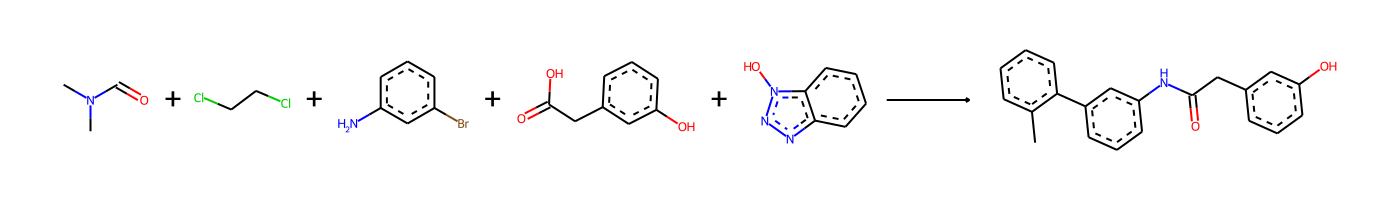

Showing path 12 with confidence 1.0:


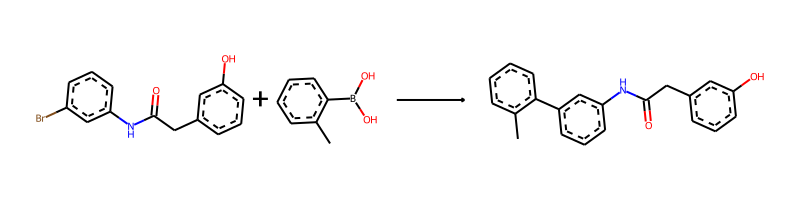

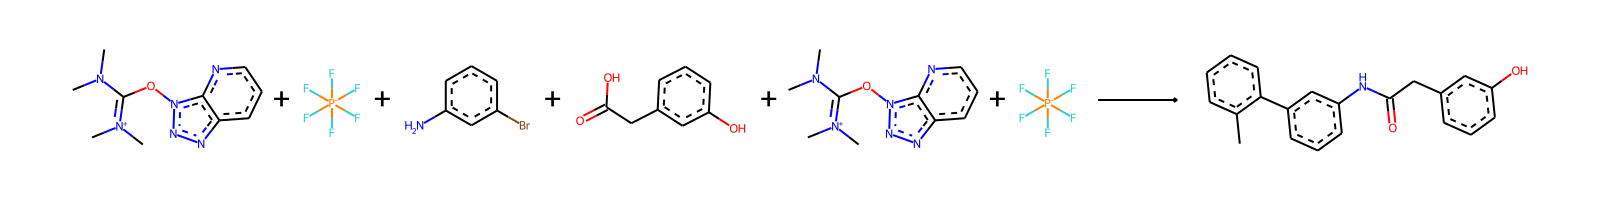

Showing path 13 with confidence 1.0:


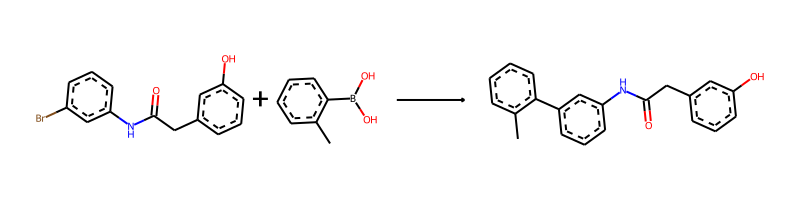

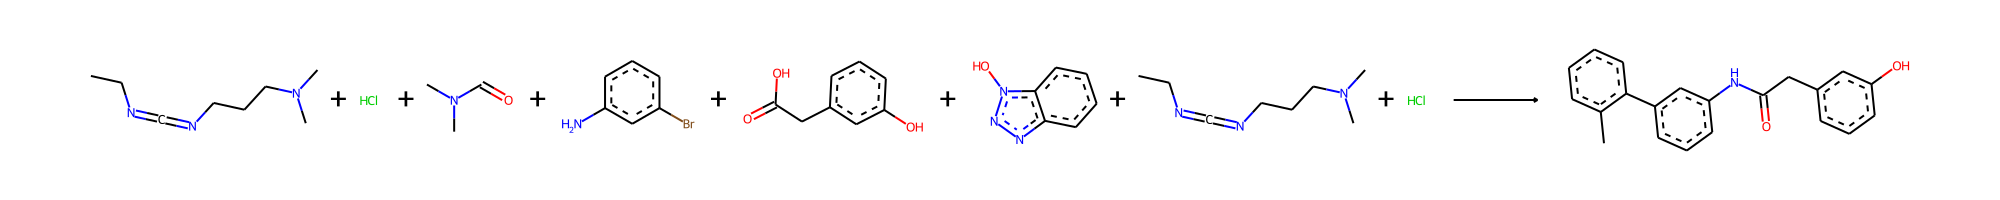

Showing path 14 with confidence 1.0:


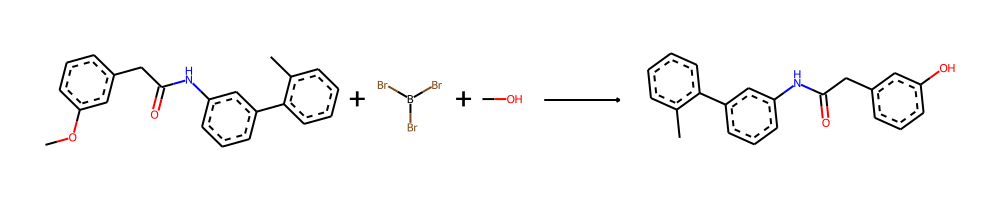

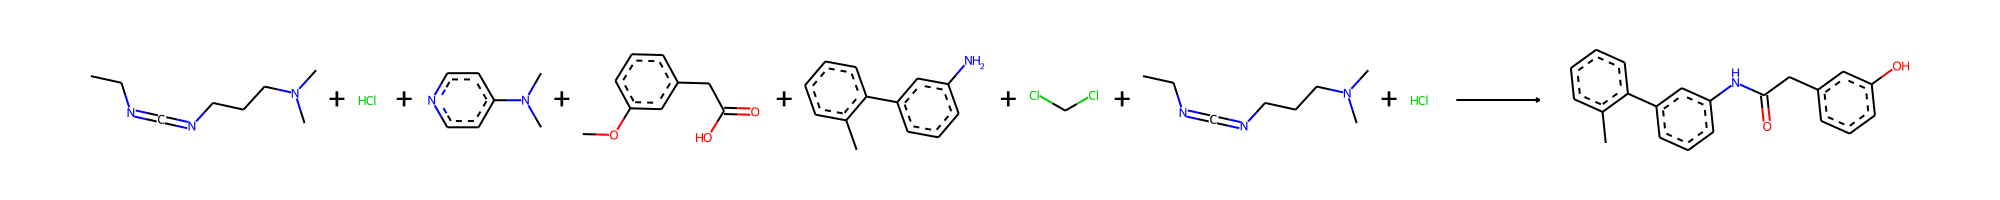

Showing path 15 with confidence 1.0:


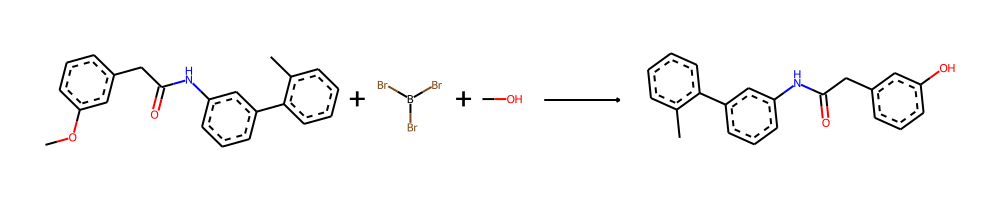

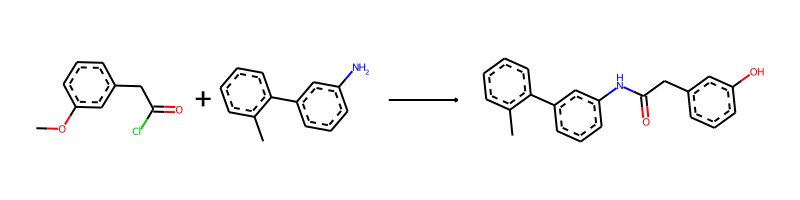

Showing path 16 with confidence 1.0:


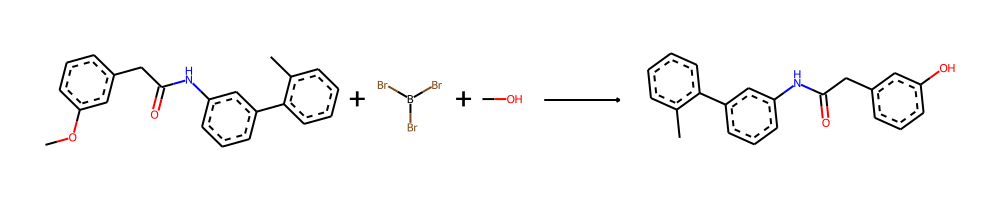

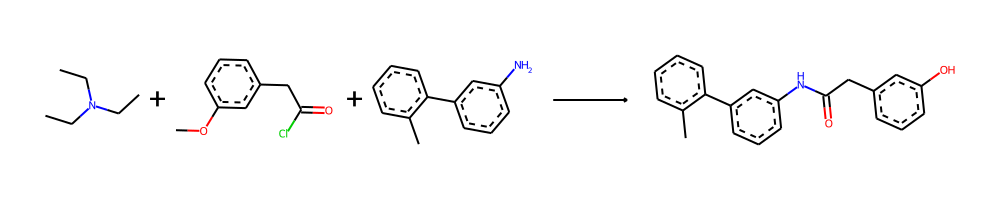

Showing path 17 with confidence 1.0:


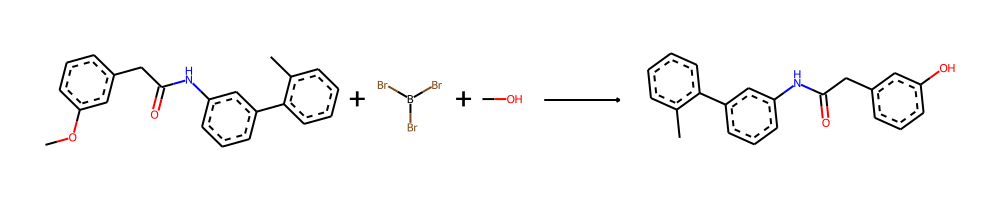

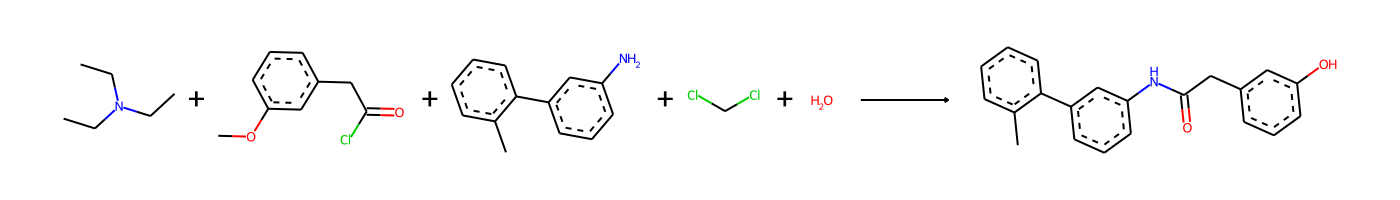

Showing path 18 with confidence 1.0:


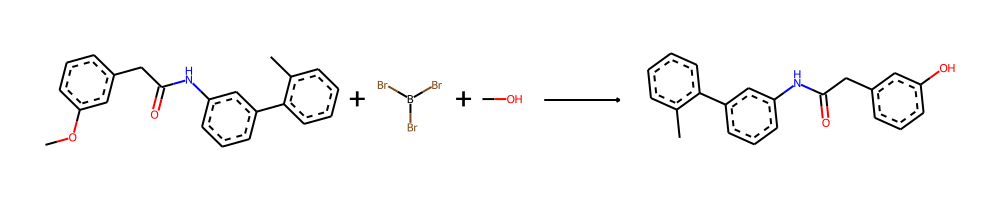

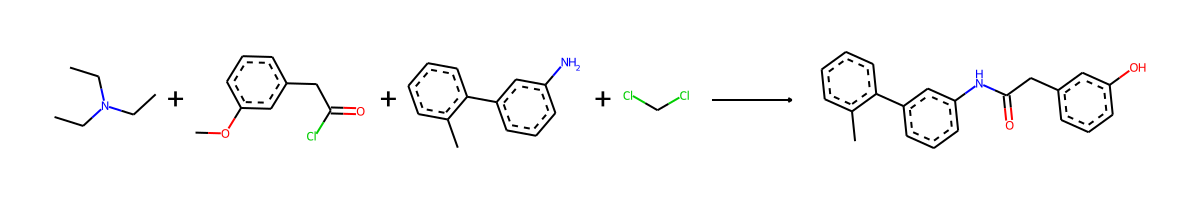

Showing path 19 with confidence 1.0:


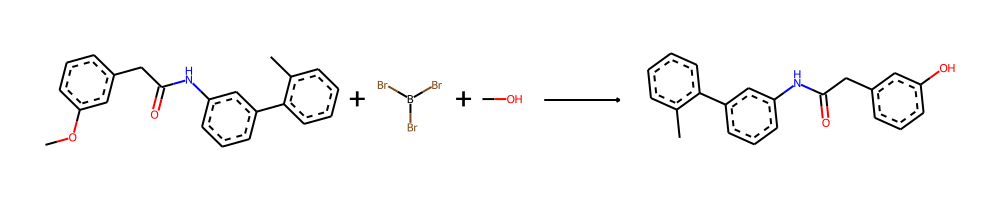

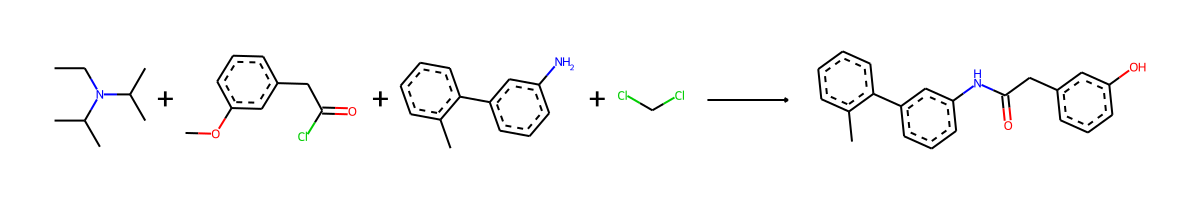

Showing path 20 with confidence 1.0:


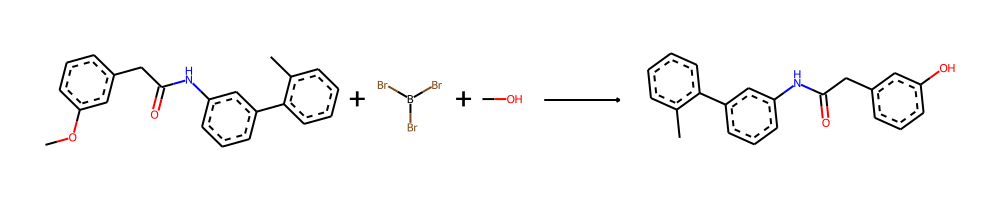

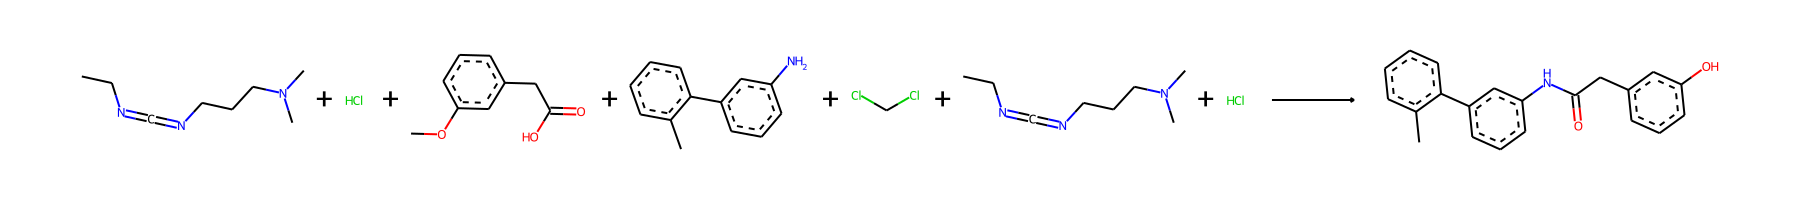

Showing path 21 with confidence 1.0:


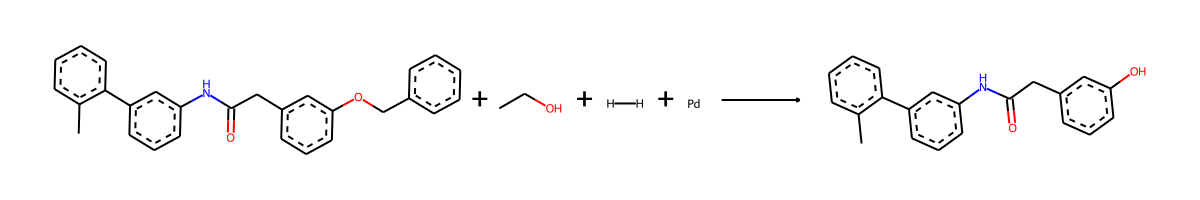

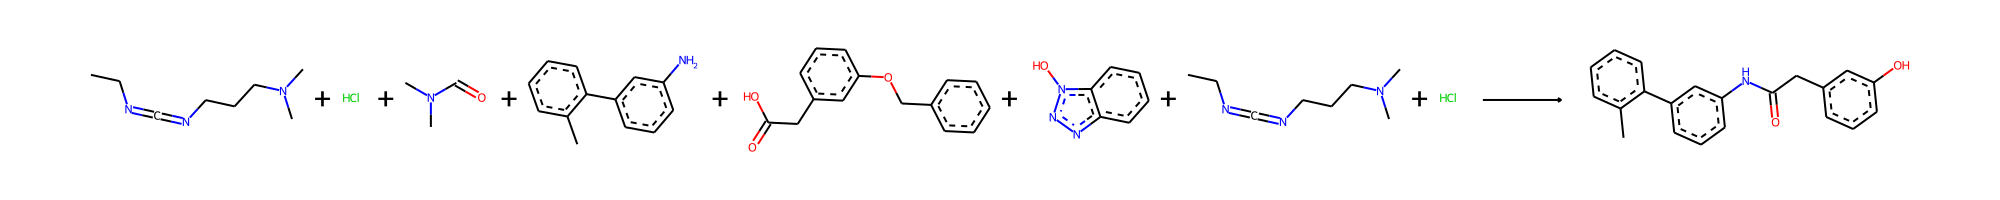

Showing path 22 with confidence 1.0:


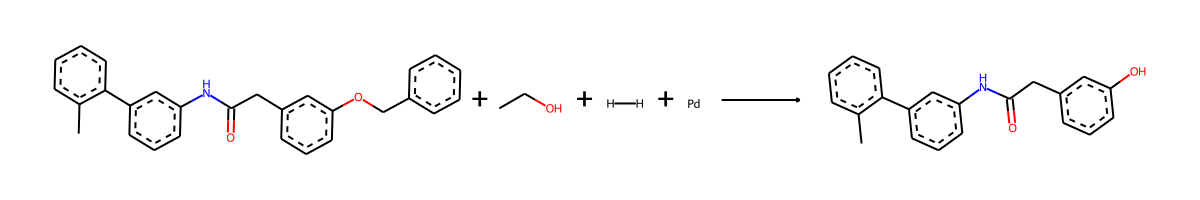

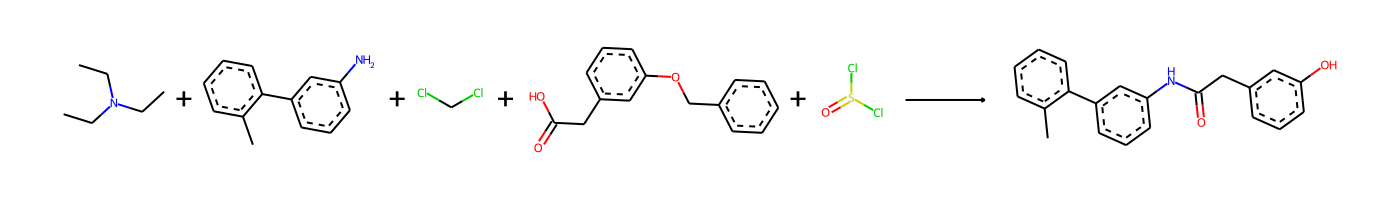

Showing path 23 with confidence 1.0:


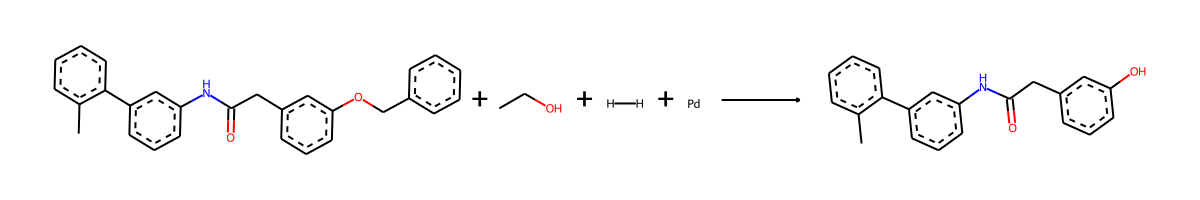

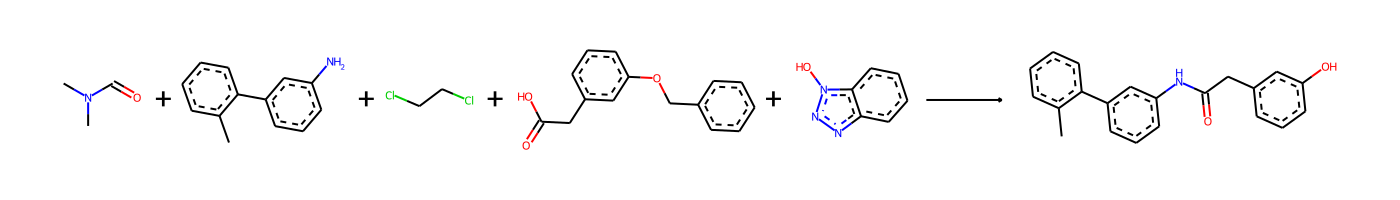

Showing path 24 with confidence 1.0:


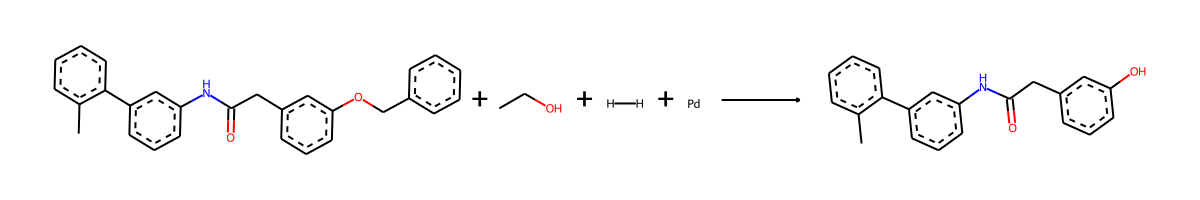

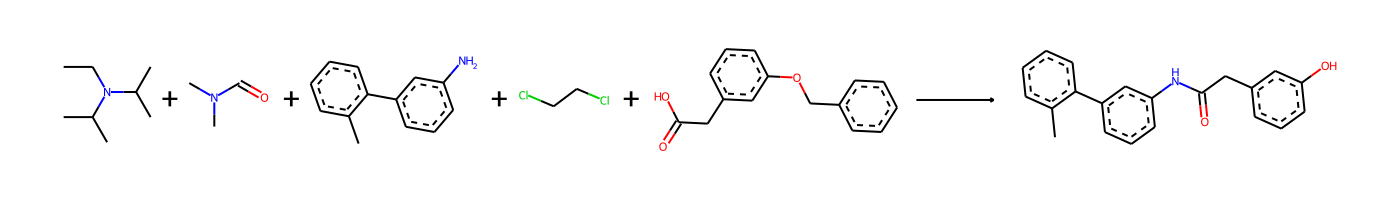

Showing path 25 with confidence 1.0:


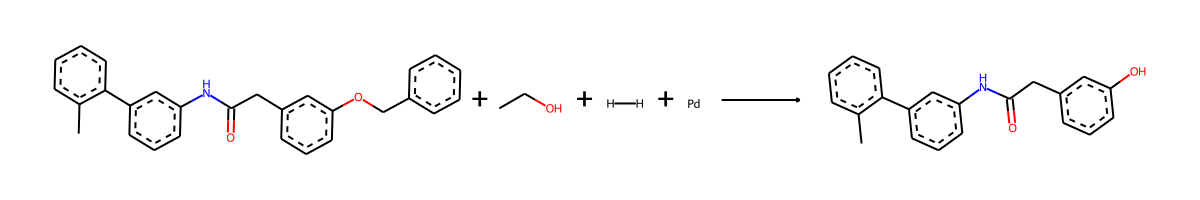

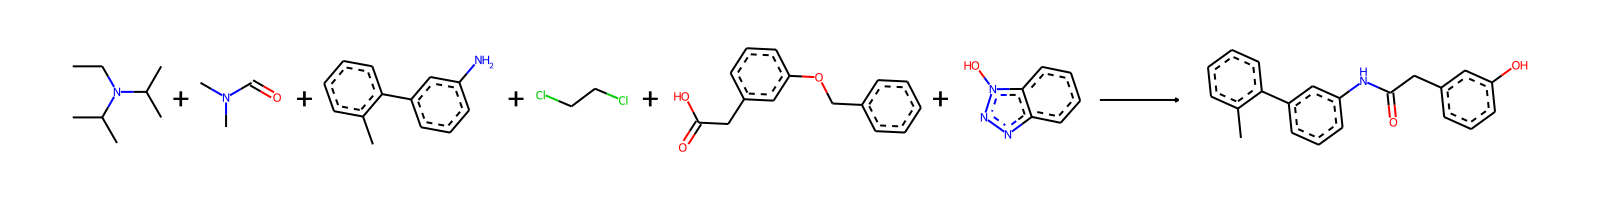

Showing path 26 with confidence 1.0:


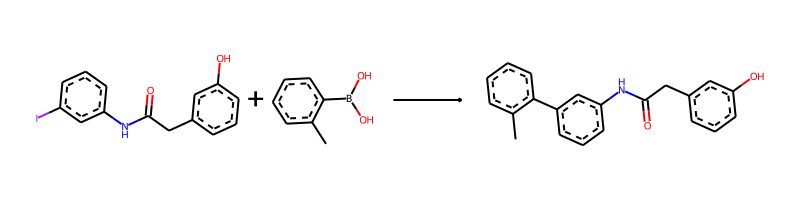

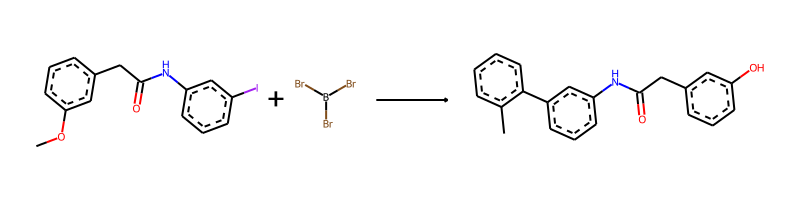

Showing path 27 with confidence 1.0:


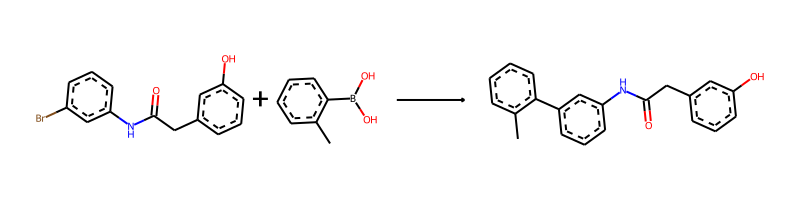

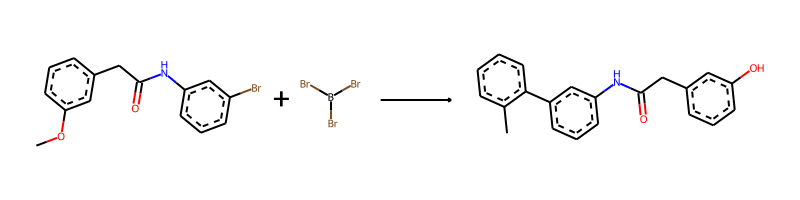

Showing path 28 with confidence 1.0:


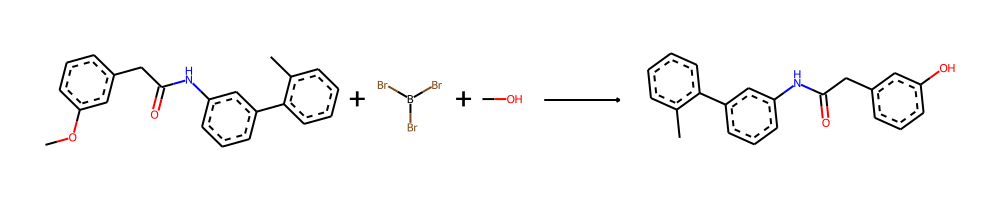

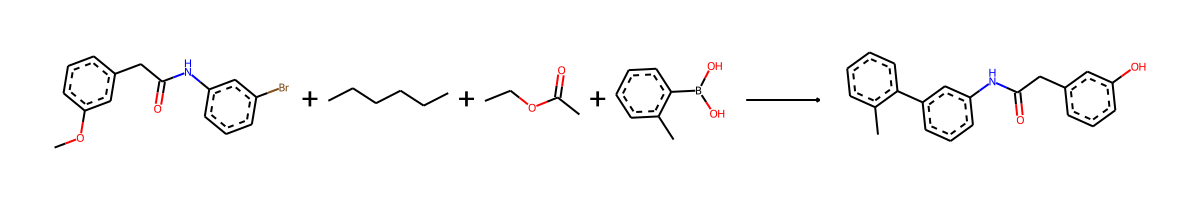

Showing path 29 with confidence 1.0:


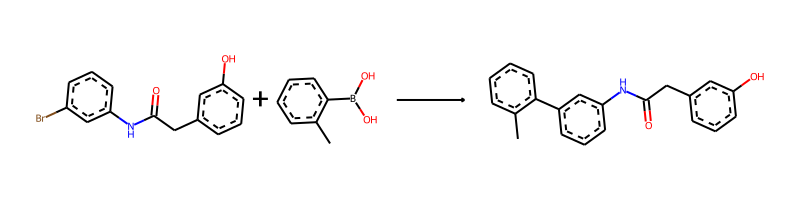

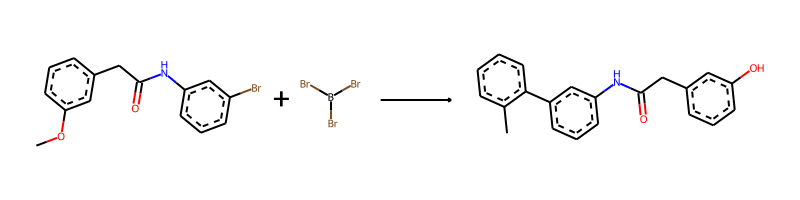

In [106]:
from rdkit.Chem import AllChem
from IPython.display import display

# Function to get all the reactions
def collect_reactions(tree):
    reaction_info = {}
    reaction_info['reactions'] = []
    reaction_info['rclass'] = []
    
    if 'children' in tree and len(tree['children']):
        reaction_info['rclass'].append(tree['rclass'])
        reaction_info['reactions'].append(
            AllChem.ReactionFromSmarts('{}>>{}'.format(
                '.'.join([node['smiles'] for node in tree['children']]),
                tree['smiles']
            ), useSmiles=True)
        )
    for node in tree['children']:
        if 'children' in node and len(node['children']):
            reaction_info['rclass'].append(node['rclass'])
            reaction_info['reactions'].append(
                AllChem.ReactionFromSmarts('{}>>{}'.format(
                    '.'.join([node['smiles'] for node in node['children']]),
                    tree['smiles']
                ), useSmiles=True)
            )
    return reaction_info

for index, path in enumerate(results['retrosynthetic_paths']):
    print('Showing path {} with confidence {}:'.format(index, path['confidence']))
    reaction_info = collect_reactions(path)
    
    for reaction in reaction_info['reactions']:
        display(Chem.Draw.ReactionToImage(reaction))

In [108]:
for pathway in results['retrosynthetic_paths']:
    reaction_info = collect_reactions(pathway)
    print('-------------------------')
    print(reaction_info)

-------------------------
{'reactions': [<rdkit.Chem.rdChemReactions.ChemicalReaction object at 0x7fe4ba767e40>], 'rclass': ['Carboxylic acid + amine condensation']}
-------------------------
{'reactions': [<rdkit.Chem.rdChemReactions.ChemicalReaction object at 0x7fe4ba767080>, <rdkit.Chem.rdChemReactions.ChemicalReaction object at 0x7fe4ba767580>], 'rclass': ['Bromo Suzuki-type coupling', 'Carboxylic acid + amine condensation']}
-------------------------
{'reactions': [<rdkit.Chem.rdChemReactions.ChemicalReaction object at 0x7fe4ba767e40>, <rdkit.Chem.rdChemReactions.ChemicalReaction object at 0x7fe4ba767670>], 'rclass': ['Methoxy to hydroxy', 'Carboxylic acid + amine condensation']}
-------------------------
{'reactions': [<rdkit.Chem.rdChemReactions.ChemicalReaction object at 0x7fe4ba767580>, <rdkit.Chem.rdChemReactions.ChemicalReaction object at 0x7fe4ba767080>], 'rclass': ['O-Bn deprotection', 'Carboxylic acid + amine condensation']}
-------------------------
{'reactions': [<rdkit

In [68]:
reaction_info = collect_reactions()

{'reaction_class': [], 'product_smiles': [], 'reactions': []}

In [ ]:
def collect_info(tree):
    info = []
    if 'children' in tree and len(tree['children']):
        print(node)
        reactions.append(
            AllChem.ReactionFromSmarts('{}>>{}'.format(
                '.'.join([node['smiles'] for node in tree['children']]),
                tree['smiles']
            ), useSmiles=True)
        )
    for node in tree['children']:
        reactions.extend(collect_reactions(node))
    return reactions

In [66]:
all_molecules = reactions['response']['payload']['molecules']

In [77]:
for molecule in all_molecules:
    if molecule['id'] == '5f4863133dc67c0001c89017':
        print(molecule['moleculeImage'])

<?xml version='1.0' encoding='UTF-8'?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<svg version='1.2' xmlns='http://www.w3.org/2000/svg' xmlns:xlink='http://www.w3.org/1999/xlink' width='36.77mm' height='33.58mm' viewBox='0 0 36.77 33.58'>
  <desc>Generated by the Chemistry Development Kit (http://github.com/cdk)</desc>
  <g stroke-linecap='round' stroke-linejoin='round' stroke='#000000' stroke-width='.21' fill='#FF0D0D'>
    <rect x='.0' y='.0' width='37.0' height='34.0' fill='#FFFFFF' stroke='none'/>
    <g id='mol1' class='mol'>
      <g id='mol1bnd1' class='bond'>
        <line x1='18.58' y1='17.67' x2='20.55' y2='14.25'/>
        <line x1='19.37' y1='18.13' x2='21.35' y2='14.71'/>
      </g>
      <line id='mol1bnd2' class='bond' x1='20.82' y1='14.71' x2='18.28' y2='10.31'/>
      <line id='mol1bnd3' class='bond' x1='18.28' y1='10.31' x2='13.2' y2='10.31'/>
      <g id='mol1bnd4' class='bond'>
        <line x1='10.66' y1='14.7

In [78]:
# Number one sequence
reaction_one = reactions['response']['payload']['sequences']
# The rest of the retro sequences
rest_reactions = reactions['response']['payload']['siblings']

In [84]:
for reaction in rest_reactions:
    print(reaction['reactions'])

[{'id': '5f4863133dc67c0001c8901c', 'metadata': {}, 'embed': {}, 'computedFields': {}, 'createdOn': 1598579475484, 'createdBy': 'system', 'modifiedOn': 1598579475484, 'modifiedBy': 'system', 'confidence': 0.988, 'confidenceTag': None, 'label': None, 'rclass': 'Methoxy to hydroxy', 'smiles': 'COc1cccc(CC(=O)Nc2cccc(-c3ccccc3C)c2)c1.Cl~c1ccncc1', 'children': [{'smiles': 'COc1cccc(CC(=O)Nc2cccc(-c3ccccc3C)c2)c1', 'metaData': {}, 'moleculeId': None, 'isExpandable': False, 'isCommercial': False}, {'smiles': 'Cl.c1ccncc1', 'metaData': {}, 'moleculeId': None, 'isExpandable': False, 'isCommercial': False}], 'metaData': None}, {'id': '5f4863123dc67c0001c89010', 'metadata': {}, 'embed': {}, 'computedFields': {}, 'createdOn': 1598579474996, 'createdBy': 'system', 'modifiedOn': 1598579474996, 'modifiedBy': 'system', 'confidence': 0.986, 'confidenceTag': None, 'label': None, 'rclass': 'Methoxy to hydroxy', 'smiles': 'BrB(Br)Br.COc1cccc(CC(=O)Nc2cccc(-c3ccccc3C)c2)c1', 'children': [{'smiles': 'BrB(B

In [48]:
reactions['response']['payload']['sequences']

[{'id': '5fc4f9c9f7b59800011bd78e',
  'metadata': {'hcomplexity': [0.3065430087154304, 0.6325840207059554],
   'status': 'DONE'},
  'embed': {},
  'computedFields': {},
  'createdOn': 1606744521603,
  'createdBy': 'system',
  'modifiedOn': 1606744611633,
  'modifiedBy': 'system',
  'user': None,
  'confidence': 1.0,
  'optimizationScore': 1.8,
  'position': 0,
  'confidenceTag': 'H',
  'name': 'Test actions_20201130_13:55:21.602',
  'outcomeMolecules': None,
  'productMolecule': None,
  'projectId': '5fc4f972f7b59800011bd75e',
  'retrosynthesisId': '5fc4f9b2f7b59800011bd77f',
  'sequenceId': None,
  'label': 'Sequence 0',
  'complexityGraph': '<?svg version="1.0" encoding="utf-8" standalone="no"?>\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"\n  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\n<!-- Created with matplotlib (http://matplotlib.org/) -->\n<svg height="345.6pt" version="1.1" viewBox="0 0 460.8 345.6" width="460.8pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http

In [ ]:
# Function to extract reactions from api response 


In [ ]:
# Functions to request info from IBM API


    
def createIBMReactionModel(smiles):
    # Function that takes in all the info from IBM API call
    # and creates a reaction object

    # Create Reaction object
    reaction = Reaction()
    # Need the method_id which is passed in as obj in argument
    # Need to have uploaded svg image to productimages folder
    method_obj = Method.objects.get(id=method_id)
    reaction.method_id = method_obj
    reaction.name = name
    reaction.productsmiles = product_smiles
    reaction.productimage = 'productimages/' + product_image_fn
    reaction.productname = product_name
    reaction.save()
    
def createProjectModel(project_info):
    # Function that creates a project object
    # if the csv file uploaded is validated and
    # the user wants to upload the data
    
    # project_info is a list of info passed into the validate/upload
    # Celery tasks
    
    project_name, submitter_name, submitter_email = project_info 

    # Create Project object
    project = Project()
    project.projectname = project_name
    project.submittername = submitter_name
    project.submitteremail = submitter_email
    project.save()
    
    
# @shared_task
def uploadIBMReaction(validate_output):
    # Validate output is a list - this is one way to get
    # Celery chaining to work where second function uses list output
    # from first function (validate) called
    validate_dict, validated, csv_fp, project_info = validate_output
    
    if not validated:
        return (validate_dict, validated)
    
    if validated:
        # Create project model
        createProjectModel(project_info)
        
        for smiles in smiles_list:
            # Get retro reaction predictions from IBM API
            reactions = getRetroSyn(smiles) 
            
        
        
    
    
#     def saveImage(self):
#         # Function to upload product image



# def getRoboActions(reactions):
#     # Each retrosynthetic path predicted has a unique sequence_id that can
#     # be used to create a new synthesis
#     response = rxn4chemistry_wrapper.create_synthesis_from_sequence(
#         sequence_id=results['retrosynthetic_paths'][0]['sequence_id'])
#     print(response['synthesis_id'])

# # get the entire list of actions for the entire synthesis, as well as a tree representation
# synthesis_tree, ordered_tree_nodes, ordered_list_of_actions = rxn4chemistry_wrapper.get_synthesis_plan(
#     synthesis_id=response['synthesis_id']
# )
# for action in ordered_list_of_actions:
#     print(action)

In [ ]:
reactions = getIBMRetroSyn(smiles[0])

In [ ]:
reactions['retrosynthetic_paths'][0]

In [ ]:
reactions['retrosynthetic_paths'][0]['children']

In [ ]:
# Each retrosynthetic path predicted has a unique sequence_id that can
# be used to create a new synthesis
response = rxn4chemistry_wrapper.create_synthesis_from_sequence(
    sequence_id=reactions['retrosynthetic_paths'][0]['sequenceId'])
print(response['synthesis_id'])

# get the entire list of actions for the entire synthesis, as well as a tree representation
synthesis_tree, ordered_tree_nodes, ordered_list_of_actions = rxn4chemistry_wrapper.get_synthesis_plan(
    synthesis_id=response['synthesis_id'])
for action in ordered_list_of_actions:
    print(action)

In [ ]:
# Need to convert names to smiles!
# Use the awesome Cactus API - https://cactus.nci.nih.gov/

from urllib.request import urlopen
from urllib.parse import quote

def CIRconvert(name):
    try:
        name_converted = quote(name)
        url= 'https://cactus.nci.nih.gov/chemical/structure/' + name_converted + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return 'Did not work'

identifiers  = ['Z-Leu-OSu']

for ids in identifiers :
    print(ids, CIRconvert(ids))